In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

import scipy.sparse as sp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone

from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from cycler import cycler

%matplotlib inline

# Loading descriptions

In [2]:
with open('data/steam_game_descriptions.txt', 'r') as f:
  reader = csv.reader(f)
  descriptions = list(reader)

In [3]:
descriptions = descriptions[0]

# Loading targets

In [4]:
with open('data/steam_complete_tag_list.txt', 'r') as f:
  reader = csv.reader(f)
  tag_names = list(reader)

In [5]:
tag_names = tag_names[0]

# Looking at the distribution across genres

In [6]:
y_mat = np.load('data/steam_tag_metrix_2.npy')

In [7]:
aggregate = sum(y_mat)

sort_idx = sorted(range(len(aggregate)), key=lambda k: aggregate[k], reverse=True)

y_label_names = [tag_names[idx] for idx in sort_idx]

In [8]:
for idx, sorted_idx in enumerate(sort_idx):
    print(idx, tag_names[sorted_idx], aggregate[sorted_idx])

0 Indie 13642.0
1 Action 10282.0
2 Adventure 7945.0
3 Casual 7088.0
4 Simulation 6900.0
5 Strategy 6435.0
6 RPG 4858.0
7 Singleplayer 4510.0
8 Multiplayer 2639.0
9 Great Soundtrack 2125.0
10 Puzzle 1993.0
11 Free to Play 1907.0
12 2D 1794.0
13 Atmospheric 1774.0
14 Platformer 1525.0
15 Open World 1474.0
16 Sci-fi 1456.0
17 Early Access 1384.0
18 Fantasy 1345.0
19 Co-op 1316.0
20 Shooter 1284.0
21 Pixel Graphics 1280.0
22 Story Rich 1236.0
23 Difficult 1195.0
24 Sports 1193.0
25 Horror 1188.0
26 Female Protagonist 1171.0
27 First-Person 1160.0
28 Massively Multiplayer 1092.0
29 Racing 1088.0
30 Anime 1066.0
31 Point & Click 1053.0
32 Funny 1048.0
33 Sandbox 1047.0
34 FPS 978.0
35 Turn-Based 958.0
36 Retro 956.0
37 Classic 955.0
38 Arcade 923.0
39 Comedy 859.0
40 Survival 829.0
41 Space 812.0
42 Family Friendly 723.0
43 Third Person 707.0
44 VR 686.0
45 Exploration 590.0
46 Shoot 'Em Up 589.0
47 Local Co-Op 569.0
48 RTS 557.0
49 Rogue-like 536.0
50 Cute 520.0
51 Tactical 517.0
52 Local M

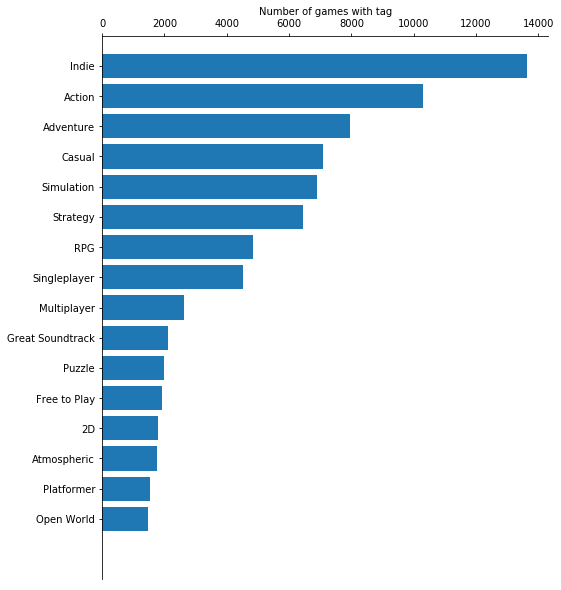

In [9]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(range(0,len(tag_names[:16])), aggregate[sort_idx[:16]])

ax.set_ylim([-1, len(tag_names[:16])+1])
ax.set_yticks(range(0,len(tag_names[:16])))
ax.set_yticklabels(y_label_names[:16]);

ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set(xlabel='Number of games with tag');

ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('steam_genre_distribution.png', bbox_inches='tight')

# Looking at a subset of the genres

In [10]:
sort_idx[2]

27

In [11]:
tag_subset_idx = [13, 16, 18, 25, 40, 53, 61, 67, 71]
idx_of_selected_tags = []
tag_names_subset = []
for tag_idx in tag_subset_idx:
    idx = sort_idx[tag_idx]
    idx_of_selected_tags.append(idx)
    print(tag_names[idx], aggregate[idx])
    tag_names_subset.append(tag_names[idx])

Atmospheric 1774.0
Sci-fi 1456.0
Fantasy 1345.0
Horror 1188.0
Survival 829.0
Zombies 516.0
Gore 421.0
Mystery 379.0
Psychological Horror 352.0


# Subsetting the data

## Getting the descriptions with one or more of the subtags

In [12]:
relevant_description_idx = []
description_subset = []
for idx, row in enumerate(y_mat):
    if np.sum(row[idx_of_selected_tags])>0:
        relevant_description_idx.append(idx)
        description_subset.append(descriptions[idx])

Write code to filter out game descriptions that have no information

In [13]:
len(relevant_description_idx)

5342

An example of a game

In [14]:
print(descriptions[relevant_description_idx[2]])
tag_indices = np.where(y_mat[relevant_description_idx[2],:]>0)[0]
for idx in tag_indices:
    print(tag_names[idx])

... 300 years after Aziraal has been banished, a brother and sister are drawn into the conflict which has flared up between the Orcs and the free world. Kyra, the hero's younger sister, suddenly disappears in mysterious circumstances.«...If my family really belongs to the chosen ones, why then have we always been as poor as church mice?
Action
Singleplayer
Multiplayer
RPG
Open World
Fantasy
Third Person
Adventure
Medieval
Action RPG
Story Rich


In [15]:
idx_of_selected_tags

[37, 21, 25, 13, 61, 53, 39, 59, 237]

In [16]:
for idx in idx_of_selected_tags:
    print(np.sum(y_mat[:, idx]))

1774.0
1456.0
1345.0
1188.0
829.0
516.0
421.0
379.0
352.0


In [18]:
y = np.zeros( (len(description_subset), len(idx_of_selected_tags)) )
for i, idx in enumerate(relevant_description_idx):
    y[i,:] = y_mat[idx, idx_of_selected_tags]

# Going from words to a vector

In [19]:
import gensim

In [20]:
def sentence_to_point(description, word_model):
    words = description.split()
    game_vec = np.zeros((300,))
    for word in words:
        if word in word_model.vocab:
            word_vec = word_model.wv[word]
            game_vec = np.add(game_vec, word_vec)
    return game_vec

In [21]:
word_model = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)  

In [23]:
X = np.zeros( (len(description_subset), 300) )
for idx, description in enumerate(description_subset):
    game_vec = sentence_to_point(description, word_model)
    X[idx,:] = game_vec

# Beginning machine learning

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
model = LogisticRegression()
model_test_collection = []
for genre in range(0,len(idx_of_selected_tags)): 
    clf_clone = clone(model)
    clf_clone.fit(X_train, y_train[:, genre])
    model_test_collection.append(clf_clone)

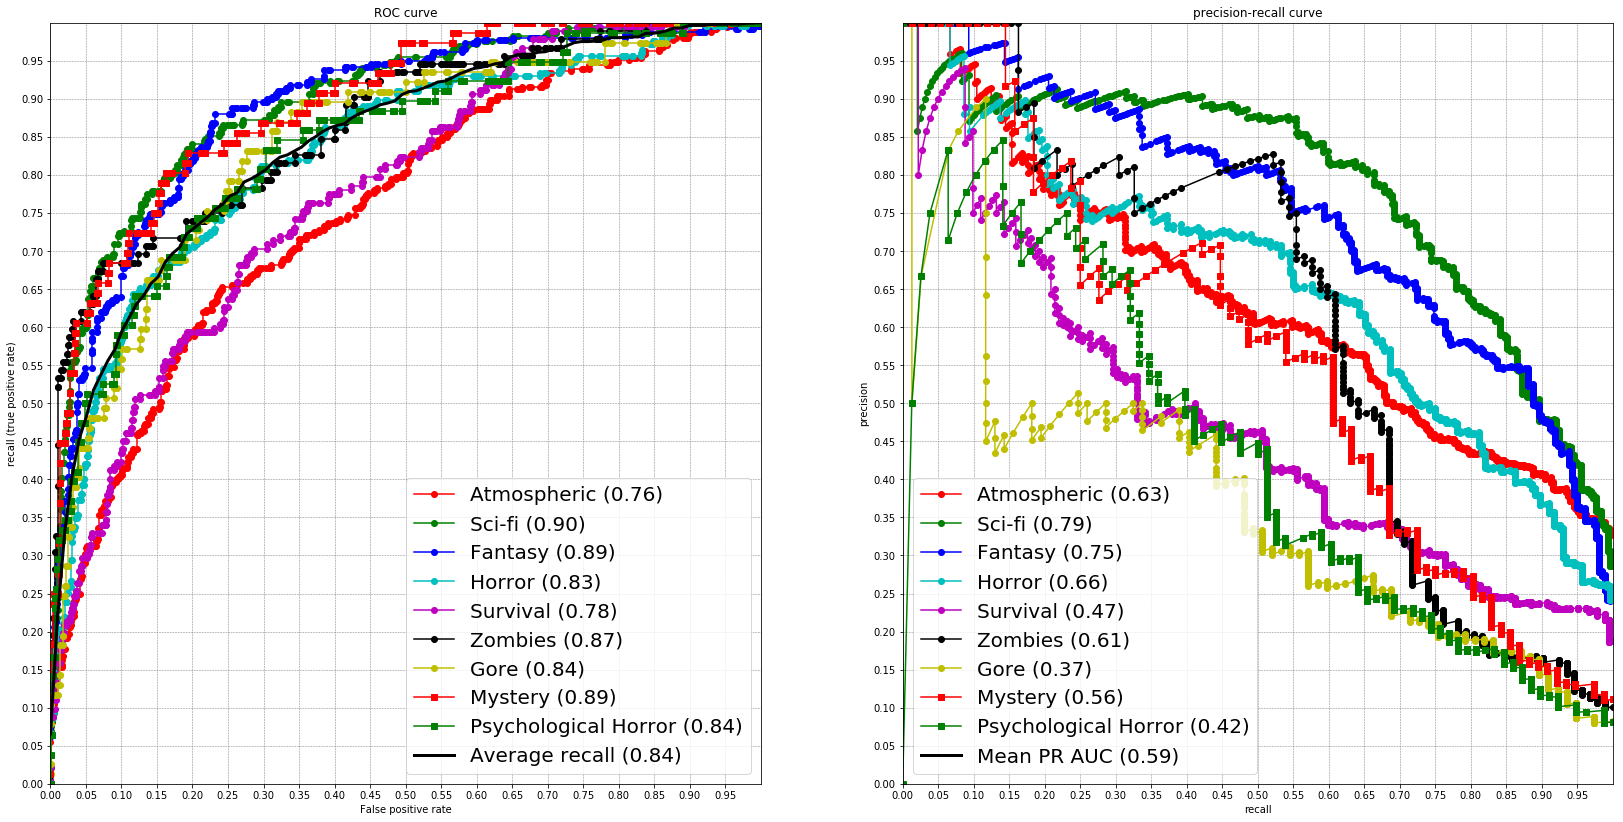

In [49]:
# Setting up the color-marker cycle
color_cycle = cycler(color=['r', 'g', 'b', 'c', 'm', 'k', 'y'])
marker_cycle = cycler(marker=['o', 's', 'v', 'x','*'])
cycle = marker_cycle * color_cycle

# Initializing the figure handles
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(28,14))

# Initializing variables that will be updated in the loop
aggregate_tpr = 0.0
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
aggregate_roc_auc = 0
aggregate_pr_auc = 0

# Helper functions 
def ticks_and_gridlines(ax):
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.0])
    ax.set(xticks=np.arange(0,1,0.05), yticks=np.arange(0,1,0.05))
    ax.grid(color='gray', linestyle='--', linewidth=.5, which='major');

# Looping over the models
for idx, (model, sty) in enumerate( zip(model_test_collection[0:12], cycle)):
    # Making the prediction
    y_score = model.predict_proba(X_test)

    # Calculating false and true positive rate
    fpr, tpr, threshold = metrics.roc_curve(y_test[:, idx], y_score[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    aggregate_tpr += np.interp(mean_fpr, fpr, tpr)

    # Calculating precision and recall
    precision, recall, threshold = metrics.precision_recall_curve(y_test[:, idx], y_score[:, 1]);
    pr_auc = metrics.auc(recall, precision)
    aggregate_pr_auc += pr_auc 

    # Plotting the metrics
    ax0.plot(fpr, tpr, **sty, label='{0} ({1:.2f})'.format(tag_names_subset[idx], roc_auc))
    ax1.plot(recall, precision, **sty, label='{0} ({1:.2f})'.format(tag_names_subset[idx], pr_auc))

# Plotting the average metrics
mean_tpr = np.divide(aggregate_tpr, (idx+1))
mean_roc_auc = metrics.auc(mean_fpr, mean_tpr)
mean_pr_auc = aggregate_pr_auc/(idx+1)

ax0.plot(mean_fpr, mean_tpr, lw=3, color='k', label='Average recall ({0:.2f})'.format(mean_roc_auc))
ax1.plot(1,1, lw=3, color='k', label='Mean PR AUC ({0:.2f})'.format(mean_pr_auc))

# Setting up labels and axis for ax0
ax0.set(xlabel='False positive rate', ylabel='recall (true positive rate)', title='ROC curve')
ax0.legend(loc="lower right", fontsize='20')
ticks_and_gridlines(ax0)

# Setting up labels and axis for ax1
ax1.set(xlabel='recall', ylabel='precision', title='precision-recall curve')
ax1.legend(loc="lower left", fontsize='20')
ticks_and_gridlines(ax1)

# Trying it out

In [39]:
example = 'In a strange future darkness lurks behind every star. With the sun about to collapse, you must find a way for the human rance to survive.'
#example = 'Madness has spread in the town. Zombies are everywhere and blood floods in the streets.'
game_vec = sentence_to_point(example, word_model)

In [43]:
pred_list = []
for idx, clf in enumerate(model_test_collection):
    pred = clf.predict_proba(game_vec.reshape(1, -1))
    pred_list.append(pred[:,1])

In [44]:
sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
my_list = [(pred_list[idx], tag_names_subset[idx]) for idx in sort_idx]
my_list

[(array([ 0.80314069]), 'Horror'),
 (array([ 0.25199862]), 'Sci-fi'),
 (array([ 0.20935357]), 'Atmospheric'),
 (array([ 0.18774092]), 'Gore'),
 (array([ 0.12699264]), 'Fantasy'),
 (array([ 0.11091927]), 'Survival'),
 (array([ 0.03889587]), 'Zombies'),
 (array([ 0.03253282]), 'Psychological Horror'),
 (array([ 0.00057838]), 'Mystery')]